In [1]:
%matplotlib inline  

from fastai.vision import *
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from efficientnet_pytorch import EfficientNet
from ranger import *
import torchvision.models as md

In [2]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def modified_label_from_df(self, cols:IntsOrStrs=1, label_cls:Callable=None, **kwargs):
    "Label `self.items` from the values in `cols` in `self.inner_df`."
    self.inner_df.labels.fillna('', inplace=True)
    labels = self.inner_df.iloc[:,df_names_to_idx(cols, self.inner_df)]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it."
    if is_listy(cols) and len(cols) > 1 and (label_cls is None or label_cls == MultiCategoryList):
        new_kwargs,label_cls = dict(one_hot=True, classes= cols),MultiCategoryList
        kwargs = {**new_kwargs, **kwargs}
    return self._label_from_list(_maybe_squeeze(labels), label_cls=label_cls, **kwargs)


def flattenAnneal(learn:Learner, lr:float, n_epochs:int, start_pct:float, SUFFIX = 'PHASE_1_COS'):
    n = len(learn.data.train_dl)
    anneal_start = int(n*n_epochs*start_pct)
    anneal_end = int(n*n_epochs) - anneal_start
    phases = [TrainingPhase(anneal_start).schedule_hp('lr', lr),
             TrainingPhase(anneal_end).schedule_hp('lr', lr, anneal=annealing_cos)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.callbacks.append(SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}'))
    learn.fit(n_epochs)

In [3]:
PATH = Path('..')
FOLD =0
BS =            512
SZ =            224
IMG_TRAIN_224 = PATH/'train_images_224'
IMG_TEST_224  = PATH/'test_images_224'
DF_TRAIN =      pd.read_csv(PATH/'train_labels_as_strings.csv')
DF_SUBMI =      pd.read_csv(PATH/'stage_1_sample_submission.csv')
EXP_NAME =      f'NB_EXP_30_CV_{FOLD}_{SZ}'


DF_SUBMI['fn'] = DF_SUBMI.ID.apply(lambda x: '_'.join(x.split('_')[:2]) + '.png')
DF_TRAIN['labels'].fillna('', inplace=True)
VAL_IDX = strt_split(DF_TRAIN['fn'], DF_TRAIN['labels'])[FOLD]

In [4]:
ItemList.label_from_df = modified_label_from_df
test_fns = DF_SUBMI.fn.unique()

tfms = get_transforms(max_rotate=30,
                      max_warp=None,
                      max_zoom = 1.4, 
                      xtra_tfms=cutout(n_holes=(4,20), length=(2, 30), p=0.5))

data = (ImageList.from_csv('..', 'train_labels_as_strings.csv', folder=IMG_TRAIN_224.name)
        .split_by_idxs(valid_idx=VAL_IDX[0], train_idx=VAL_IDX[1])
        .label_from_df(label_delim=' ')
         
        .add_test('../' +IMG_TEST_224.name + '/' + test_fns)
        .databunch(bs=BS)
        .normalize(imagenet_stats))

        

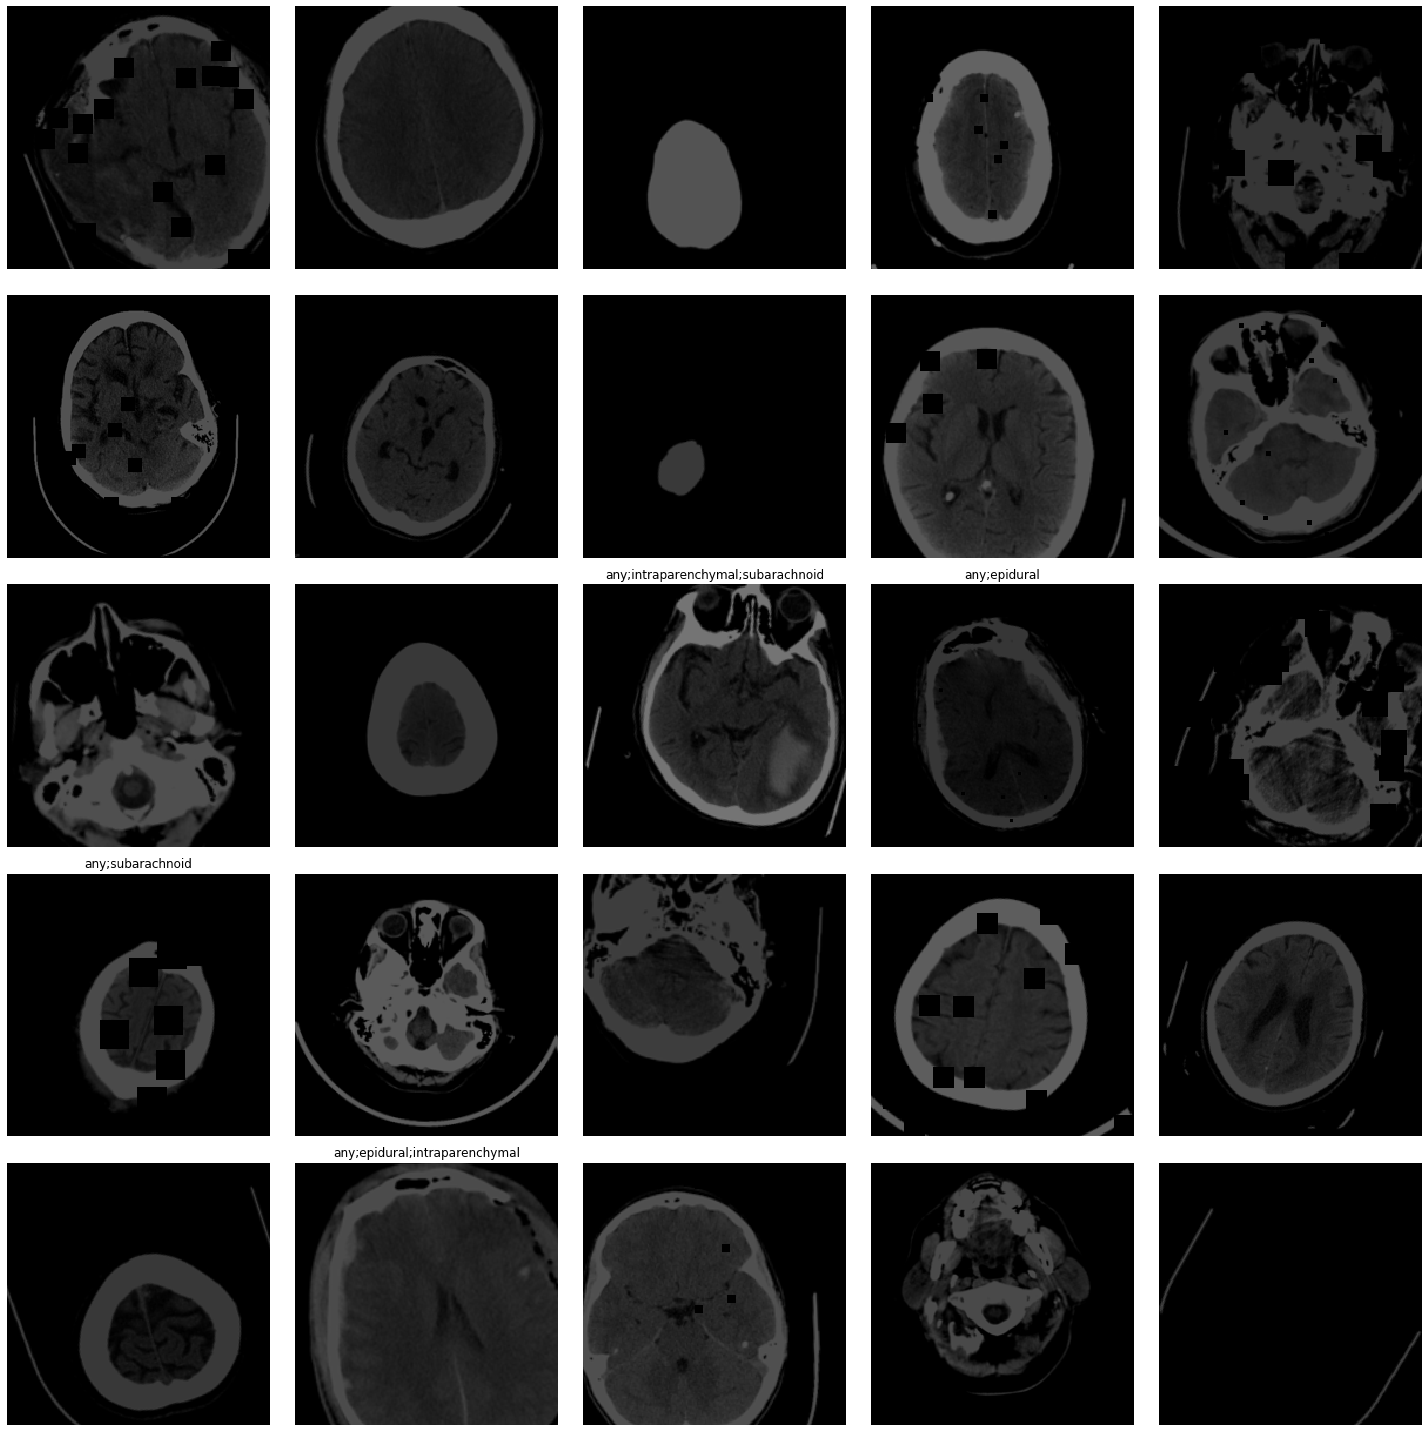

In [5]:
data.show_batch()

In [6]:
learn = cnn_learner(data,
                md.resnext50_32x4d,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh])

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


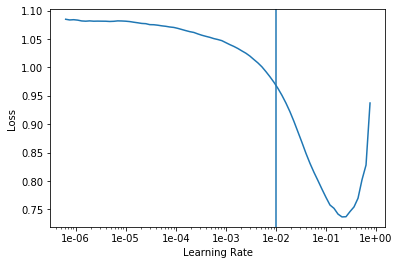

In [12]:
lr = 1e-2
learn.recorder.plot()
plt.axvline(lr)

In [13]:
SUFFIX = 'PHASE_1_1CYL'
learn.fit_one_cycle(10,
                    lr, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = f'{EXP_NAME}_{SUFFIX}')])

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.100883,0.092980,0.966862,14:31
1,0.096934,0.091373,0.967946,14:19
2,0.092378,0.089209,0.968189,14:21
3,0.089190,0.087813,0.969644,14:21
4,0.085299,0.085692,0.970341,14:25
5,0.084350,0.081093,0.971559,14:22
6,0.081165,0.075987,0.973089,14:27
7,0.078241,0.073815,0.973464,14:19
8,0.076380,0.072534,0.973737,14:21
9,0.075399,0.072314,0.973952,14:23


Better model found at epoch 0 with valid_loss value: 0.0929802656173706.
Better model found at epoch 1 with valid_loss value: 0.09137334674596786.
Better model found at epoch 2 with valid_loss value: 0.08920947462320328.
Better model found at epoch 3 with valid_loss value: 0.08781255036592484.
Better model found at epoch 4 with valid_loss value: 0.08569242060184479.
Better model found at epoch 5 with valid_loss value: 0.08109261840581894.
Better model found at epoch 6 with valid_loss value: 0.07598669826984406.
Better model found at epoch 7 with valid_loss value: 0.07381518185138702.
Better model found at epoch 8 with valid_loss value: 0.07253393530845642.
Better model found at epoch 9 with valid_loss value: 0.07231399416923523.


In [7]:
opt_func = partial(Ranger, betas=(0.92,0.99), eps=1e-6, N_sma_threshhold=4)

In [8]:
learn = cnn_learner(data,
                md.resnext50_32x4d,
                wd=1e-2,
                bn_wd=False, 
                true_wd=True, 
                metrics=[accuracy_thresh], 
                opt_func=opt_func)

learn.model = nn.DataParallel(learn.model)
learn.to_fp16()
learn.load('NB_EXP_30_CV_0_224_PHASE_1_1CYL')
learn.unfreeze()

set state called


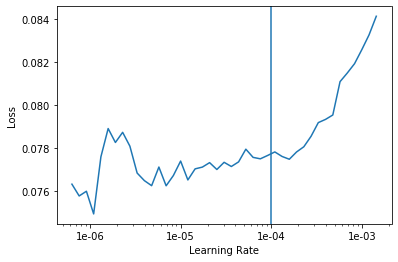

In [13]:
lr = 1e-4
learn.recorder.plot(skip_end=30)
plt.axvline(lr)

In [9]:
lr = 1e-4

In [ ]:
flattenAnneal(learn, lr, 30, 0.68)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.076827,0.072118,0.974087,18:13
1,0.074800,0.069327,0.975096,17:55
2,0.070473,0.068307,0.975396,17:53
3,0.071315,0.066819,0.976012,17:58
4,0.067467,0.066118,0.975979,17:57
5,0.068168,0.064780,0.976455,17:51
6,0.065835,0.065340,0.976566,17:55
7,0.065135,0.063694,0.977108,17:56
8,0.064599,0.063127,0.977109,17:51
9,0.065239,0.062199,0.977511,17:48


Better model found at epoch 0 with valid_loss value: 0.07211751490831375.
Better model found at epoch 1 with valid_loss value: 0.0693274587392807.
Better model found at epoch 2 with valid_loss value: 0.06830696761608124.
Better model found at epoch 3 with valid_loss value: 0.06681888550519943.
Better model found at epoch 4 with valid_loss value: 0.06611835956573486.
Better model found at epoch 5 with valid_loss value: 0.06477979570627213.
Better model found at epoch 7 with valid_loss value: 0.06369376182556152.
Better model found at epoch 8 with valid_loss value: 0.06312698125839233.
Better model found at epoch 9 with valid_loss value: 0.06219915300607681.
Better model found at epoch 10 with valid_loss value: 0.06190052628517151.
Better model found at epoch 11 with valid_loss value: 0.06145482137799263.
Better model found at epoch 12 with valid_loss value: 0.06111488118767738.
Better model found at epoch 14 with valid_loss value: 0.060418035835027695.


In [ ]:
def get_preds(learn:Learner, sub_fn: str=f'{EXP_NAME}_COS', TTA: bool = False, dt_type = DatasetType.Test):
    if TTA:
        learn.to_fp32()
        preds, targs = learn.TTA(ds_type=dt_type)
        sub_fn = f'{sub_fn}_TTA'
    else:
        preds, targs = learn.get_preds(dt_type)
    ids = []
    labels = []

    for fn, pred in zip(test_fns, preds):
        for i, label in enumerate(data.train_ds.classes):
            ids.append(f"{fn.split('.')[0]}_{label}")
            predicted_probability = '{0:1.10f}'.format(pred[i].item())
            labels.append(predicted_probability)
    pd.DataFrame({'ID': ids, 'Label': labels}).to_csv(f'{sub_fn}.csv', index=False)

In [ ]:
get_preds(learn)

In [ ]:
get_preds(learn, TTA=True)